In [1]:
import numpy as np
import os
import torch
from scipy.io import loadmat
from sklearn.pipeline import make_pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
from h5py import File
from scripts.dataset import Dataset
from scripts.model import EEGNet, OTSNet, OTSLoss, TTSNet, TTSLoss
from skorch import NeuralNetClassifier, NeuralNet
from skorch.callbacks import EpochScoring
from skorch.callbacks.scoring import ScoringBase
# from torch.utils.tensorboard import SummaryWriter

In [2]:
class EpochScoringonTest(ScoringBase):
    def __init__(self, test_data, test_label, 
                scoring,
                lower_is_better=False,
                on_train=False,
                name=None,
                use_caching=False) -> None:
        super(EpochScoringonTest, self).__init__(
            scoring=scoring,
            lower_is_better=lower_is_better, 
            on_train=on_train,
            name=name, 
            use_caching=use_caching)
        self.test_data = test_data
        self.test_label = test_label

    def _record_score(self, history, current_score):
        """Record the current store and, if applicable, if it's the best score
        yet.

        """
        history.record(self.name_, current_score)

        is_best = self._is_best_score(current_score)
        if is_best is None:
            return

        history.record(self.name_ + '_best', bool(is_best))
        if is_best:
            self.best_score_ = current_score

    # pylint: disable=unused-argument
    def on_epoch_end(self, net, **kwargs):
        net.training = False
        current_score = net.score(self.test_data, self.test_label)
        self._record_score(net.history, current_score)

In [3]:
if __name__=="__main__":
    Fs = 256
    num_fold = 5
    num_subj = 10
    num_epoch= 500
    num_class= 5
    lr_rate = 0.002
    max_freq = 10
    step_bank= 2
    frange = np.arange(step_bank,max_freq+1,step_bank)
    channels = np.arange(62)#(np.int64([1,3,5,15,29,30,31,45,55,57,59])-1).tolist()
    num_bank = int(max_freq/step_bank)
    t  = [0, 2]
    accuracy_test  = np.zeros([num_subj, num_fold, num_epoch])
    torch.manual_seed(1169456885)
    np.random.seed(1169456885)
    for sub in range(num_subj):
        dataset=Dataset(num_class=num_class,path='/Volumes/我是硬盘/Dataset/OData/Dataset II/', channel=channels)
        dataset.load_data(sub, 'zscore')
        dataset.divide_data(num_fold)
        dataset.filter_data(fs=Fs, frange=frange, order=8)
        for fold in tqdm(range(num_fold), desc=f'Sub{sub}:'):
            train_set, train_label, test_set, test_label = dataset.retreive_data(
                    class_index=np.arange(num_class), fold_index=fold, filter_index=np.arange(num_bank)+1, precison='*')
            train_set = np.transpose(train_set[:,:,int(t[0]*Fs):int(t[1]*Fs),:], (0,3,1,2))
            test_set  = np.transpose(test_set[:,:,int(t[0]*Fs):int(t[1]*Fs), :], (0,3,1,2))
            net = TTSNet(num_classes=num_class, num_samples=int(t[1]-t[0])*Fs, num_fbanks=num_bank, num_channels=len(channels))
            model = NeuralNetClassifier(
                net,
                max_epochs=num_epoch,
                criterion=TTSLoss(),
                lr=lr_rate,
                optimizer=torch.optim.Adam,
                device='cpu',
                callbacks=[EpochScoringonTest(test_set, test_label, scoring='accuracy', name='test_acc',
                                              on_train=False)]
            )
            model.set_params(train_split=None, verbose=0)
            model.fit(train_set, train_label)
            accuracy_test[sub,fold,:] = model.history[:, 'test_acc']
            # result[sub,fold] =model.score(test_set, test_label)
                

Sub0::   0%|          | 0/5 [00:12<?, ?it/s]


KeyError: "Key 'test_acc' was not found in history."

In [ ]:
if __name__=="__main__":
    Fs = 256
    num_fold = 5
    num_subj = 10
    num_epoch= 500
    num_class= 5
    lr_rate = 0.002
    max_freq = 10
    step_bank= 2
    frange = np.arange(step_bank,max_freq+1,step_bank)
    channels = np.arange(62)#(np.int64([1,3,5,15,29,30,31,45,55,57,59])-1).tolist()
    num_bank = int(max_freq/step_bank)
    t  = [0, 2]
    accuracy_test  = np.zeros([num_subj, num_fold, num_epoch])
    torch.manual_seed(1169456885)
    np.random.seed(1169456885)
    for sub in range(num_subj):
        dataset=Dataset(num_class=num_class,path='/Volumes/我是硬盘/Dataset/OData/Dataset II/', channel=channels)
        dataset.load_data(sub, 'zscore')
        dataset.divide_data(num_fold)
        dataset.filter_data(fs=Fs, frange=frange, order=8)
        for fold in tqdm(range(num_fold), desc=f'Sub{sub}:'):
            train_set, train_label, test_set, test_label = dataset.retreive_data(
                    class_index=np.arange(num_class), fold_index=fold, filter_index=np.arange(num_bank)+1, precison='*')
            train_set = np.transpose(train_set[:,:,int(t[0]*Fs):int(t[1]*Fs),:], (0,3,1,2))
            test_set  = np.transpose(test_set[:,:,int(t[0]*Fs):int(t[1]*Fs), :], (0,3,1,2))
            net = TTSNet(num_classes=num_class, num_samples=int(t[1]-t[0])*Fs, num_fbanks=num_bank, num_channels=len(channels))
            model = NeuralNetClassifier(
                net,
                max_epochs=num_epoch,
                criterion=TTSLoss(),
                lr=lr_rate,
                optimizer=torch.optim.Adam,
                device='cpu',
                callbacks=[EpochScoringonTest(test_set, test_label, scoring='accuracy', name='test_acc',
                                              on_train=False)]
            )
            model.set_params(train_split=None, verbose=0)
            model.fit(train_set, train_label)
            accuracy_test[sub,fold,:] = model.history[:, 'test_acc']
            # result[sub,fold] =model.score(test_set, test_label)
                

Sub0::   0%|          | 0/5 [00:02<?, ?it/s]


RuntimeError: Given input size: (16x1x4). Calculated output size: (16x1x0). Output size is too small

In [5]:
if __name__=="__main__":
    Fs = 256
    num_fold = 5
    num_subj = 10
    num_epoch= 500
    num_class= 5
    lr_rate = 0.002
    max_freq = 10
    step_bank= 2
    frange = np.arange(step_bank,max_freq+1,step_bank)
    channels = np.arange(62)#(np.int64([1,3,5,15,29,30,31,45,55,57,59])-1).tolist()
    num_bank = int(max_freq/step_bank)
    t  = [0, 2]
    accuracy_test  = np.zeros([num_subj, num_fold, num_epoch])
    torch.manual_seed(1169456885)
    np.random.seed(1169456885)
    for sub in range(num_subj):
        dataset=Dataset(num_class=num_class,path='/Volumes/我是硬盘/Dataset/OData/Dataset II/', channel=channels)
        dataset.load_data(sub, 'zscore')
        dataset.divide_data(num_fold)
        dataset.filter_data(fs=Fs, frange=frange, order=8)
        for fold in tqdm(range(num_fold), desc=f'Sub{sub}:'):
            train_set, train_label, test_set, test_label = dataset.retreive_data(
                    class_index=np.arange(num_class), fold_index=fold, filter_index=np.arange(num_bank)+1, precison='*')
            train_set = np.transpose(train_set[:,:,int(t[0]*Fs):int(t[1]*Fs),:], (0,3,1,2))
            test_set  = np.transpose(test_set[:,:,int(t[0]*Fs):int(t[1]*Fs), :], (0,3,1,2))
            net = TTSNet(num_classes=num_class, num_samples=int(t[1]-t[0])*Fs, num_fbanks=num_bank, num_channels=len(channels))
            model = NeuralNetClassifier(
                net,
                max_epochs=num_epoch,
                criterion=TTSLoss(),
                lr=lr_rate,
                optimizer=torch.optim.Adam,
                device='cpu',
                callbacks=[EpochScoringonTest(test_set, test_label, scoring='accuracy', name='test_acc',
                                              on_train=False)]
            )
            model.set_params(train_split=None, verbose=0)
            model.fit(train_set, train_label)
            accuracy_test[sub,fold,:] = model.history[:, 'test_acc']
            # result[sub,fold] =model.score(test_set, test_label)
                

Sub0::   0%|          | 0/5 [00:01<?, ?it/s]


RuntimeError: Given input size: (16x1x4). Calculated output size: (16x1x0). Output size is too small

In [8]:
from scipy.io import savemat
savemat('accuracy_datasetII_ttsnet_62chn_2e3_500.mat', {'accuracy':accuracy_test})

In [5]:
if __name__=="__main__":
    Fs = 256
    num_fold = 5
    num_subj = 10
    num_epoch= 500
    num_class= 5
    lr_rate = 0.002
    max_freq = 10
    step_bank= 2
    frange = np.arange(step_bank,max_freq+1,step_bank)
    channels = np.arange(62)#(np.int64([1,3,5,15,29,30,31,45,55,57,59])-1).tolist()
    num_bank = int(max_freq/step_bank)
    t  = [0, 2]
    accuracy_test  = np.zeros([num_subj, num_fold, num_epoch])
    torch.manual_seed(1169456885)
    np.random.seed(1169456885)
    for sub in range(num_subj):
        dataset=Dataset(num_class=num_class,path='Dataset/OData/Dataset II/', channel=channels)
        dataset.load_data(sub, None)
        dataset.divide_data(num_fold)
        dataset.filter_data(fs=Fs, frange=frange, order=8)
        for fold in tqdm(range(num_fold), desc=f'Sub{sub}:'):
            train_set, train_label, test_set, test_label = dataset.retreive_data(
                    class_index=np.arange(num_class), fold_index=fold, filter_index=np.arange(num_bank)+1, precison='*')
            train_set = np.transpose(train_set[:,:,int(t[0]*Fs):int(t[1]*Fs),:], (0,3,1,2))
            test_set  = np.transpose(test_set[:,:,int(t[0]*Fs):int(t[1]*Fs), :], (0,3,1,2))
            net = TTSNet(num_classes=num_class, num_samples=int(t[1]-t[0])*Fs, num_fbanks=num_bank, num_channels=len(channels))
            model = NeuralNetClassifier(
                net,
                max_epochs=num_epoch,
                criterion=TTSLoss(),
                lr=lr_rate,
                optimizer=torch.optim.Adam,
                device='cuda',
                callbacks=[EpochScoringonTest(test_set, test_label, scoring='accuracy', name='test_acc',
                                              on_train=False)]
            )
            model.set_params(train_split=None, verbose=0)
            model.fit(train_set, train_label)
            accuracy_test[sub,fold,:] = model.history[:, 'test_acc']
            # result[sub,fold] =model.score(test_set, test_label)
                

Sub9:: 100%|██████████| 5/5 [29:00<00:00, 348.11s/it]


In [6]:
from scipy.io import savemat
savemat('accuracy_datasetII_ttsnet_62chn_2e3_500_nz.mat', {'accuracy':accuracy_test})

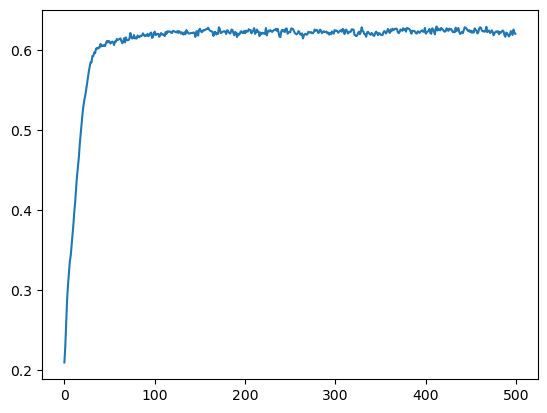

In [7]:
plt.plot(np.mean(accuracy_test, axis=(0,1)))

In [8]:
from scipy.io import loadmat
data = loadmat('accuracy_datasetII_ttsnet_62chn_2e3_500.mat')
accuracy_test11 = data['accuracy']
data = loadmat('accuracy_datasetII_ttsnet_62chn_2e3_500_nz.mat')
accuracy_test61 = data['accuracy']

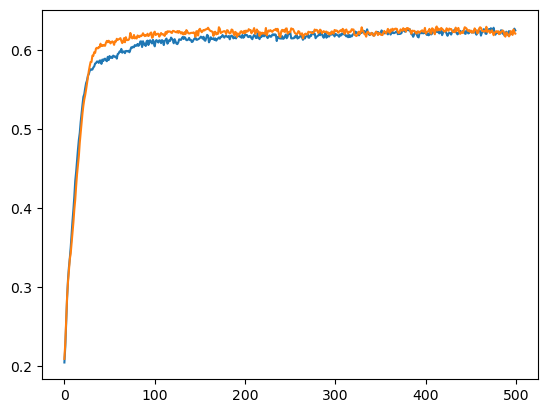

In [9]:
plt.plot(np.mean(accuracy_test11[:15,:,:], axis=(0,1)))
plt.plot(np.mean(accuracy_test61[:15,:,:], axis=(0,1)))